# 1. Predictive Model Selection for Seasonal Stream Forecasting

---------

- **Data Structure**: Panel data of 7 Christmas songs, with weekly streams from 2017 to 2025, concentrated in the high-season (weeks 45-52).
- **Modeling Approach**: The core methodology transforms the data into multiple, independent time series. For each song, a separate time series is created for each week of the Christmas season (e.g., one series for Week 45 streams across all years, another for Week 46, etc.).
- **Time Series Characteristics**: Each resulting time series is short, containing approximately 8 data points (one for each year from 2017-2024), representing the year-over-year performance for a specific week. This isolates the annual trend and simplifies the forecasting challenge by removing complex seasonality.


| **Criterion**         | **Moving Average**                      | **ARIMA (Chosen)**                                    | **LSTM**                                       | **Prophet**                                         |
|-----------------------|-----------------------------------------|-------------------------------------------------------|------------------------------------------------|-----------------------------------------------------|
| **Complexity**        | Very Low                                | Low - Simple ARIMA(1,1,1) used                        | Very High - Neural network architecture        | Medium - Automated but complex for this use case    |
| **Data Requirements** | Minimal                                 | **Ideal for short series (8 data points/year)**       | Very Large - Requires thousands of data points | Moderate - Best with longer, more granular data     |
| **Seasonality**       | None                                    | Not needed; seasonality is handled by the data split  | Learns patterns but needs huge data            | Overkill; designed for multi-level seasonality      |
| **Interpretability**  | High                                    | High - Clear statistical parameters (p,d,q)           | Very Low - Black-box model                     | Medium - Decomposes trend/seasonality               |
| **Training Time**     | Instant                                 | Very Fast - Milliseconds per model                    | Slow - Minutes to hours                        | Fast                                                |
| **Overfitting Risk**  | None                                    | Low - Few parameters, simple model                    | **Extremely High** - Unusable on 8 data points | High - Would overfit on such a short series         |
| **Trend Capture**     | Poor - Only smooths                     | Excellent - Differencing (d=1) captures year-over-year trend | Can learn trends, but not with 8 data points   | Good, but not optimized for this data structure     |
| **Suitability**       | **Poor** - Only a baseline              | **Excellent** - Optimal balance for this methodology  | **Unsuitable** - Requires vastly more data     | **Poor** - Wrong tool for short, annual series      |




The selected modeling approach—building an independent **ARIMA(1,1,1) model for each week of the Christmas season per song**—is uniquely suited to the dataset's structure. This method effectively transforms the problem into a series of simple, univariate forecasts on short time series (approx. 8 annual data points each), making complex models not only unnecessary but inappropriate.

- **ARIMA** was chosen because it is statistically robust and highly effective for short series where the primary goal is to model year-over-year trends and autocorrelation. Its simplicity, low computational cost, and high interpretability make it the perfect fit.

- **LSTM** networks were discarded due to the extremely small size of each individual time series. Attempting to train a deep learning model on only 8 data points would result in immediate, severe overfitting, producing meaningless forecasts.

- **Prophet**, while powerful for time series with daily or weekly granularity and multiple seasonalities, is not designed for this specific setup. Its features for modeling holiday effects and complex cycles are overkill and would likely fail to produce reliable results on a short series of annual data points.

I transformed the complex forecasting problem by decomposing each song's data into independent, annual mini-series for each week of the Christmas season (Weeks 45-52+1). This created simple 8-point time series capturing year-over-year trends for specific weekly snapshots. An ARIMA(1,1,1) model was then fitted to each series, providing a statistically robust approach suitable for such short sequences. This method intentionally sacrifices intra-seasonal pattern recognition to focus exclusively on annual trend forecasting with minimal complexity.

# 2. The ARIMA Model: Theoretical Foundation

------------



The **ARIMA(p,d,q)** model combines three components to forecast time series:

**AR(p) - Autoregressive**: Uses *past values* as predictors  
`y_t = c + φ₁y_{t-1} + ... + φ_py_{t-p} + ε_t`

**I(d) - Integration**: Differences the series *d times* to achieve stationarity  
`Δy_t = y_t - y_{t-1}`

**MA(q) - Moving Average**: Uses *past forecast errors* as predictors  
`y_t = c + ε_t + θ₁ε_{t-1} + ... + θ_qε_{t-q}`

### General Linear Equation: ARIMA(p,d,q)

$$Y_t = c + \underbrace{\phi_1 Y_{t-1} + \dots + \phi_p Y_{t-p}}_{\text{AR: Past Values}} + \underbrace{\theta_1 \varepsilon_{t-1} + \dots + \theta_q \varepsilon_{t-q}}_{\text{MA: Past Errors}} + \varepsilon_t$$

#### Legend and Concepts:

* **$Y_t$ — Where is the "I" (Integration)?**
  This $Y_t$ is **not** the raw data, but the series **after differentiation** $d$ times (made stationary).
  * The **"I"** is the pre-processing step: $Y_t = \text{Data}_t - \text{Data}_{t-1}$.
  * The model attempts to forecast this *difference* (change), not the absolute value directly.

* **$\phi_p \times Y_{t-p}$ — The "AR" Term (Autoregressive):**
  Regression based on the series' own past values.
  * **Concept:** "If the value (or change) was high yesterday, it will likely be high today (inertia/momentum)."
  * $\phi$: Represents the weight/importance of the past.

* **$\theta_q \times \varepsilon_{t-q}$ — The "MA" Term (Moving Average):**
  Regression based on past forecast errors.
  * **Concept:** "If I made a large error in yesterday's forecast (an unexpected shock), I will use that error to adjust today's forecast."
  * $\varepsilon_{t-q}$: The residual (error) that occurred in the past.

* **$c$ and $\varepsilon_t$:**
  * $c$: A constant (intercept or drift).
  * $\varepsilon_t$: The current white noise (the new random error happening today that cannot be predicted).

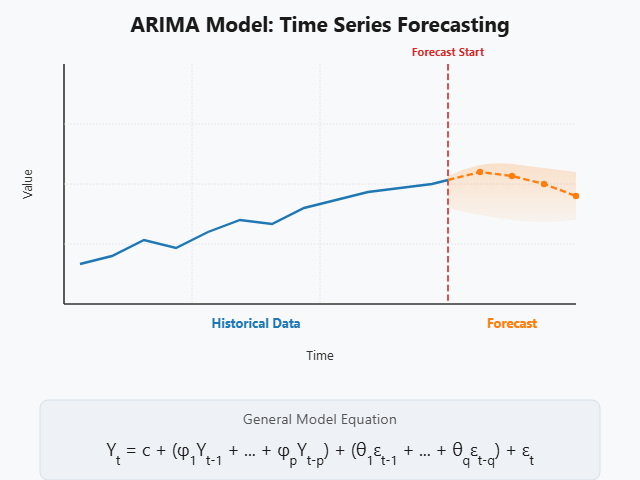

In [5]:
pip install pandas numpy matplotlib statsmodels scikit-learn jupyter

  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ----------------- ---------------------- 4.2/9.5 MB 24.3 MB/s eta 0:00:01
   ---------------------------------------  9.4/9.5 MB 26.6 MB/s eta 0:00:01
   ---------------------------------------- 9.5/9.5 MB 22.1 MB/s  0:00:00
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------  7.9/8.0 MB 39.4 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 34.5 MB/s  0:00:00
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   -------- ------------------------------- 8.1/38.5 MB 40.0 MB/s eta 0:00:01
   ---------------- ----------------------- 16.0/38.5 MB 39.1 MB/s eta 0:00:0


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd


# 3. Model Training and Testing

---------------

In [7]:
import pandas as pd
csv_path = "../data/raw/spotify_christmas_streams_kworb_2017_2025.csv" #Load the dataset
df = pd.read_csv(csv_path) #read the csv dataset
print(f"Shape: {df.shape}")
df.head()

Shape: (376, 6)


,date,track,artist,streams,day_of_week,week_of_year
0,2017-11-16,All I Want for Christmas Is You,Mariah Carey,3821572,Thursday,46
1,2017-11-23,All I Want for Christmas Is You,Mariah Carey,6130250,Thursday,47
2,2017-11-23,Last Christmas,Wham!,4040197,Thursday,47
3,2017-11-30,All I Want for Christmas Is You,Mariah Carey,11641888,Thursday,48
4,2017-11-30,It's Beginning to Look a Lot Like Christmas,Michael Bublé,4577042,Thursday,48


In [8]:
#prepare data
df['date'] = pd.to_datetime(df['date']) #column with date in date format
df['year'] = df['date'].dt.year #year column
df['week_of_year'] = df['date'].dt.isocalendar().week #column with week of year
df_christmas = df[df['week_of_year'].between(45, 52)].copy()#Filter weeks 45-52 (Nov-Dec)

songs = df_christmas['track'].unique()[:9]  #Top 7 songs
print(f"Analyzing {len(songs)} songs")

matrices_per_song = {}# Create matrices per song (year x week)

for song in songs: #for each song
    song_data = df_christmas[df_christmas['track'] == song] #top 7
    matrix = song_data.pivot_table( #create matrix with year, week of year and sum of streams 
        index='year',
        columns='week_of_year',
        values='streams',
        aggfunc='sum'
    )
    matrices_per_song[song] = matrix #create the above matrix for each song in top7

actual_2025 = df_christmas[df_christmas['year'] == 2025].copy()# Separate 2025 data (only early November)

print(" Matrices created successfully!")
print(f"Available years: {sorted(df_christmas['year'].unique())}")
print(matrix)
print(actual_2025)

Analyzing 7 songs
 Matrices created successfully!
Available years: [np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025)]
week_of_year         46          47          48          49          50  \
year                                                                      
2017                NaN         NaN         NaN         NaN         NaN   
2018                NaN         NaN   7220464.0  12304877.0  13163696.0   
2019                NaN         NaN   5558342.0  10901943.0  12457545.0   
2020                NaN   6085366.0   9678255.0  17455348.0  20577119.0   
2021                NaN   7804649.0  14983449.0  19754610.0  21479503.0   
2022          7084762.0  11660973.0  18954484.0  24811088.0  29842872.0   
2023          8609753.0  13175644.0  22186368.0  33402002.0  30951467.0   
2024          8712411.0  13038832.0  18729517.0  30821472.0  36801037.0   
2025          8905332.0  12045395.0  1

- Preparing model for prediction and splitting dataset:

In [9]:
models_per_song = {}  #training with data from 2017 to 2024 for each song
validation_2024 = {} #validation with 2024 data
forecasts_2025 = {} #forecast for 2025 data
print("\nTraining ARIMA(1,1,1) models per week per song...")

for song in songs: #for each song
    matrix = matrices_per_song[song] #the matrix of total sum per week in year for each song
    song_models = {} 
    validation_results = {} #Validation results
    forecast_values = {} #forecast results
    for week in range(45, 53): #for each week of Christmas season
        if week in matrix.columns:
            week_series = matrix[week].dropna() #remove weeks without data for all songs (Some songs are not in top 200 at the beginning of season)
            if len(week_series) >= 5: # check if there are more than 5 week data points for analysis
                train_series = week_series[week_series.index <= 2023] #training data, being non-null week data (47 - 53) up to 2023
                try:
                    model = ARIMA(train_series.values, order=(1, 1, 1)) #Train ARIMA model
                    fitted_model = model.fit() #Train model
                    song_models[week] = fitted_model
                    if 2024 in week_series.index:
                        pred_2024 = fitted_model.forecast(steps=1)[0] #Validation for 2024 data, it will try to predict 2024 week data for each song to validate the model
                        actual_2024 = week_series[2024] #the actual values of each week in 2024
                        error_pct = abs(pred_2024 - actual_2024) / actual_2024 * 100 #calculate error being (predicted - actual)/predicted
                        validation_results[week] = { #store results per week of 2024
                            'predicted': pred_2024, #predicted values
                            'actual': actual_2024, #actual values
                            'error_pct': error_pct #error
                        }
                    forecast_2steps = fitted_model.forecast(steps=2) # Forecast for 2025 (2 steps ahead)
                    pred_2025 = forecast_2steps[1]  #predict models for 2025.
                    forecast_values[week] = pred_2025

                except Exception as e:
                    print(f"  Error in {song} week {week}: {e}")
                    continue

    # Save results
    if song_models:
        models_per_song[song] = song_models
    if validation_results:
        validation_2024[song] = validation_results
    if forecast_values:
        forecasts_2025[song] = pd.Series(forecast_values)


Training ARIMA(1,1,1) models per week per song...


c:\Users\Jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

In [10]:
print("VALIDATION - 2024")
for song in songs: #for all songs
    if song in validation_2024 and validation_2024[song]: #only enters this loop if the song trained up to 2023 had validation data in 2024
        #it may be that the song didn't have enough data in 2024
        errors = [v['error_pct'] for v in validation_2024[song].values()] #Get percentage error in all valid weeks of 2024
        mape = np.mean(errors) #mean of errors
        print(f"{song[:40]:40s} | MAPE = {mape:6.1f}%")

VALIDATION - 2024
All I Want for Christmas Is You          | MAPE =   15.5%
Last Christmas                           | MAPE =   18.7%
It's Beginning to Look a Lot Like Christ | MAPE =   21.6%
Rockin' Around the Christmas Tree        | MAPE =   19.4%
Santa Tell Me                            | MAPE =    8.8%
Feliz Navidad                            | MAPE =   12.0%
Jingle Bell Rock                         | MAPE =   15.7%


- to visualize the error of each week

In [11]:
print("VALIDATION - 2024 - error analysis")
for song in songs:
    if song in validation_2024 and validation_2024[song]:
        print(f"\n{song}")
        print("Week | Error (%)")
        print("-" * 20)
        for week, v in validation_2024[song].items(): #returns key and value for each song, week and error
            #45: {'error_pct': 12.3}
            print(f"{week:>6} | {v['error_pct']:6.1f}%")


VALIDATION - 2024 - error analysis

All I Want for Christmas Is You
Week | Error (%)
--------------------
    45 |   18.2%
    46 |   12.0%
    47 |    7.4%
    48 |   35.8%
    49 |   20.2%
    50 |    8.2%
    51 |   10.2%
    52 |   11.8%

Last Christmas
Week | Error (%)
--------------------
    46 |    9.9%
    47 |   25.4%
    48 |   64.4%
    49 |   11.1%
    50 |    2.3%
    51 |    2.4%
    52 |   15.1%

It's Beginning to Look a Lot Like Christmas
Week | Error (%)
--------------------
    47 |    5.9%
    48 |   21.1%
    49 |   37.8%
    50 |   27.7%
    51 |   31.8%
    52 |    5.3%

Rockin' Around the Christmas Tree
Week | Error (%)
--------------------
    47 |   21.1%
    48 |   42.2%
    49 |   21.5%
    50 |    3.5%
    51 |   13.3%
    52 |   14.9%

Santa Tell Me
Week | Error (%)
--------------------
    47 |    1.4%
    48 |   15.6%
    49 |   11.4%
    50 |    3.0%
    51 |    9.6%
    52 |   12.1%

Feliz Navidad
Week | Error (%)
--------------------
    48 |   16.2%


In [12]:
import matplotlib.pyplot as plt

- Plotting validation and training data and comparing error each week

[np.float64(11.279139), np.float64(14.796703), np.float64(21.363813), np.float64(28.988715), np.float64(44.056478), np.float64(47.514211), np.float64(51.621732), np.float64(92.506541)]
[np.float64(13.334901884942871), np.float64(16.57552883077433), np.float64(22.952840833034024), np.float64(39.37375201155795), np.float64(52.96653709654883), np.float64(51.39546257290072), np.float64(56.87905536295721), np.float64(81.62484912692015)]
[np.float64(13.711333), np.float64(19.555376), np.float64(26.812906), np.float64(43.542785), np.float64(46.992149), np.float64(50.554131), np.float64(91.090914)]
[np.float64(15.070079553864662), np.float64(24.524850388639255), np.float64(44.08118851123032), np.float64(48.37272272729201), np.float64(48.052355022969884), np.float64(51.77566705243916), np.float64(77.35944476842049)]
[np.float64(9.94124), np.float64(14.210678), np.float64(22.538475), np.float64(24.073016), np.float64(26.548915), np.float64(47.360169)]
[np.float64(9.352083510452397), np.float64(1

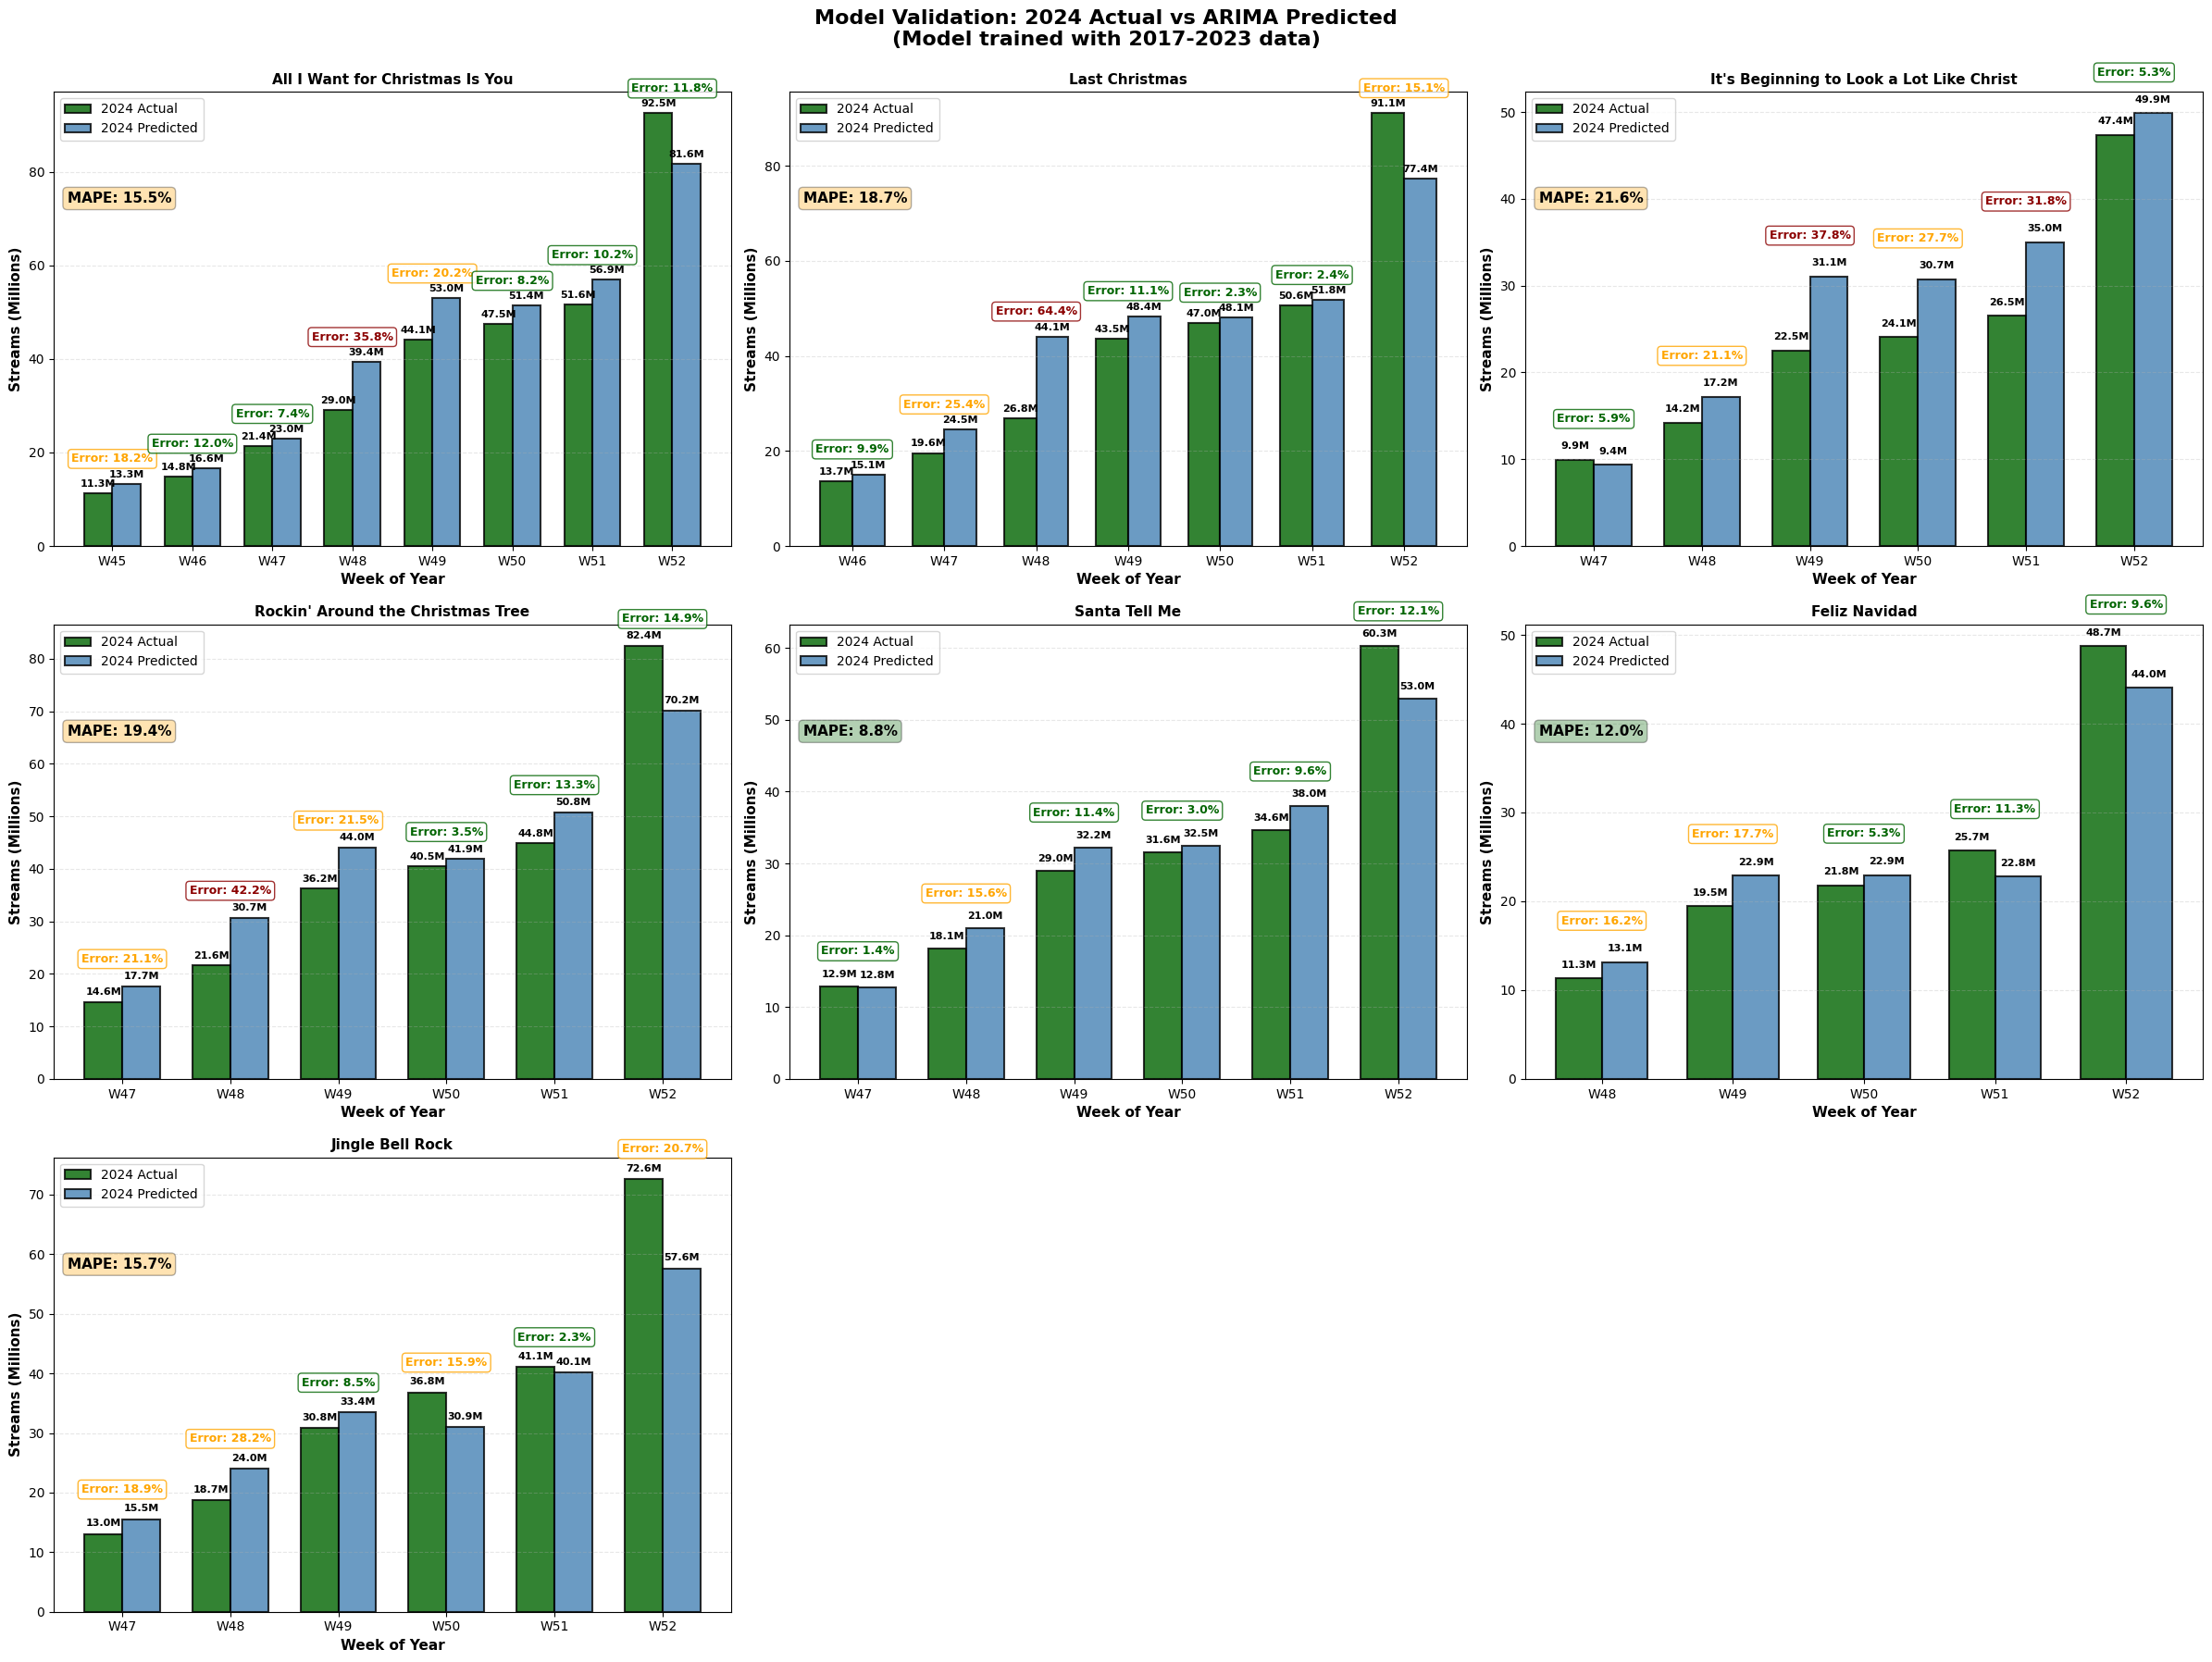

In [13]:

# CHART: VALIDATION 2024 (Actual vs Predicted)

fig, axes = plt.subplots(3, 3, figsize=(24, 18))
axes = axes.flatten()

for idx, song in enumerate(songs): #for each song
    if song not in validation_2024 or not validation_2024[song]: #check if validation analysis was done
        axes[idx].text(0.5, 0.5, f'{song}\nNo validation data',  
                      ha='center', va='center', fontsize=10)
        axes[idx].axis('off')
        continue
    
    validation = validation_2024[song] #validation data for each week of 2024 for each song 
    weeks = sorted(validation.keys()) #sort weeks
    actual_values = [validation[w]['actual'] / 1e6 for w in weeks] #actual values of 2024 (the real ones), and convert to millions
    print(actual_values)
    predicted_values = [validation[w]['predicted'] / 1e6 for w in weeks] #predicted values 
    print(predicted_values)
    errors = [validation[w]['error_pct'] for w in weeks] #error for each week
    
    # Bar chart
    x = np.arange(len(weeks))
    width = 0.35
    bars1 = axes[idx].bar(x - width/2, actual_values, width,  #bar chart with actual values in green color
                          label='2024 Actual', color='darkgreen', alpha=0.8, 
                          edgecolor='black', linewidth=1.5)
    bars2 = axes[idx].bar(x + width/2, predicted_values, width, 
                          label='2024 Predicted', color='steelblue', alpha=0.8,  #bar chart with blue color for predicted
                          edgecolor='black', linewidth=1.5)
    
    # Add stream values on bars
    for i, (actual, pred) in enumerate(zip(actual_values, predicted_values)):
        axes[idx].text(i - width/2, actual + 1, f'{actual:.1f}M', 
                      ha='center', va='bottom', fontsize=8, fontweight='bold')
        axes[idx].text(i + width/2, pred + 1, f'{pred:.1f}M',
                      ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    #Add % error
    for i, error in enumerate(errors):
        max_val = max(actual_values[i], predicted_values[i])
        error_color = 'darkgreen' if error < 15 else 'orange' if error < 30 else 'darkred'
        axes[idx].text(i, max_val + 4, f'Error: {error:.1f}%',
                      ha='center', va='bottom', fontsize=9, fontweight='bold',
                      color=error_color,
                      bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                               edgecolor=error_color, alpha=0.8))
    
    # Formatting
    axes[idx].set_xlabel('Week of Year', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Streams (Millions)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{song[:40]}', fontsize=11, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels([f'W{w}' for w in weeks], fontsize=10)
    axes[idx].legend(fontsize=10, loc='upper left')
    axes[idx].grid(True, alpha=0.3, linestyle='--', axis='y')
    # MAPE ->  mean error (all errors divided by number of weeks)
    mape = np.mean(errors)
    mape_color = 'darkgreen' if mape < 15 else 'orange' if mape < 30 else 'darkred'
    axes[idx].text(0.02, 0.78, f'MAPE: {mape:.1f}%',
                  transform=axes[idx].transAxes, fontsize=11, fontweight='bold',
                  verticalalignment='top', horizontalalignment='left',
                  bbox=dict(boxstyle='round', facecolor=mape_color, 
                           edgecolor='black', alpha=0.3))

for idx in range(len(songs), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Model Validation: 2024 Actual vs ARIMA Predicted\n(Model trained with 2017-2023 data)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

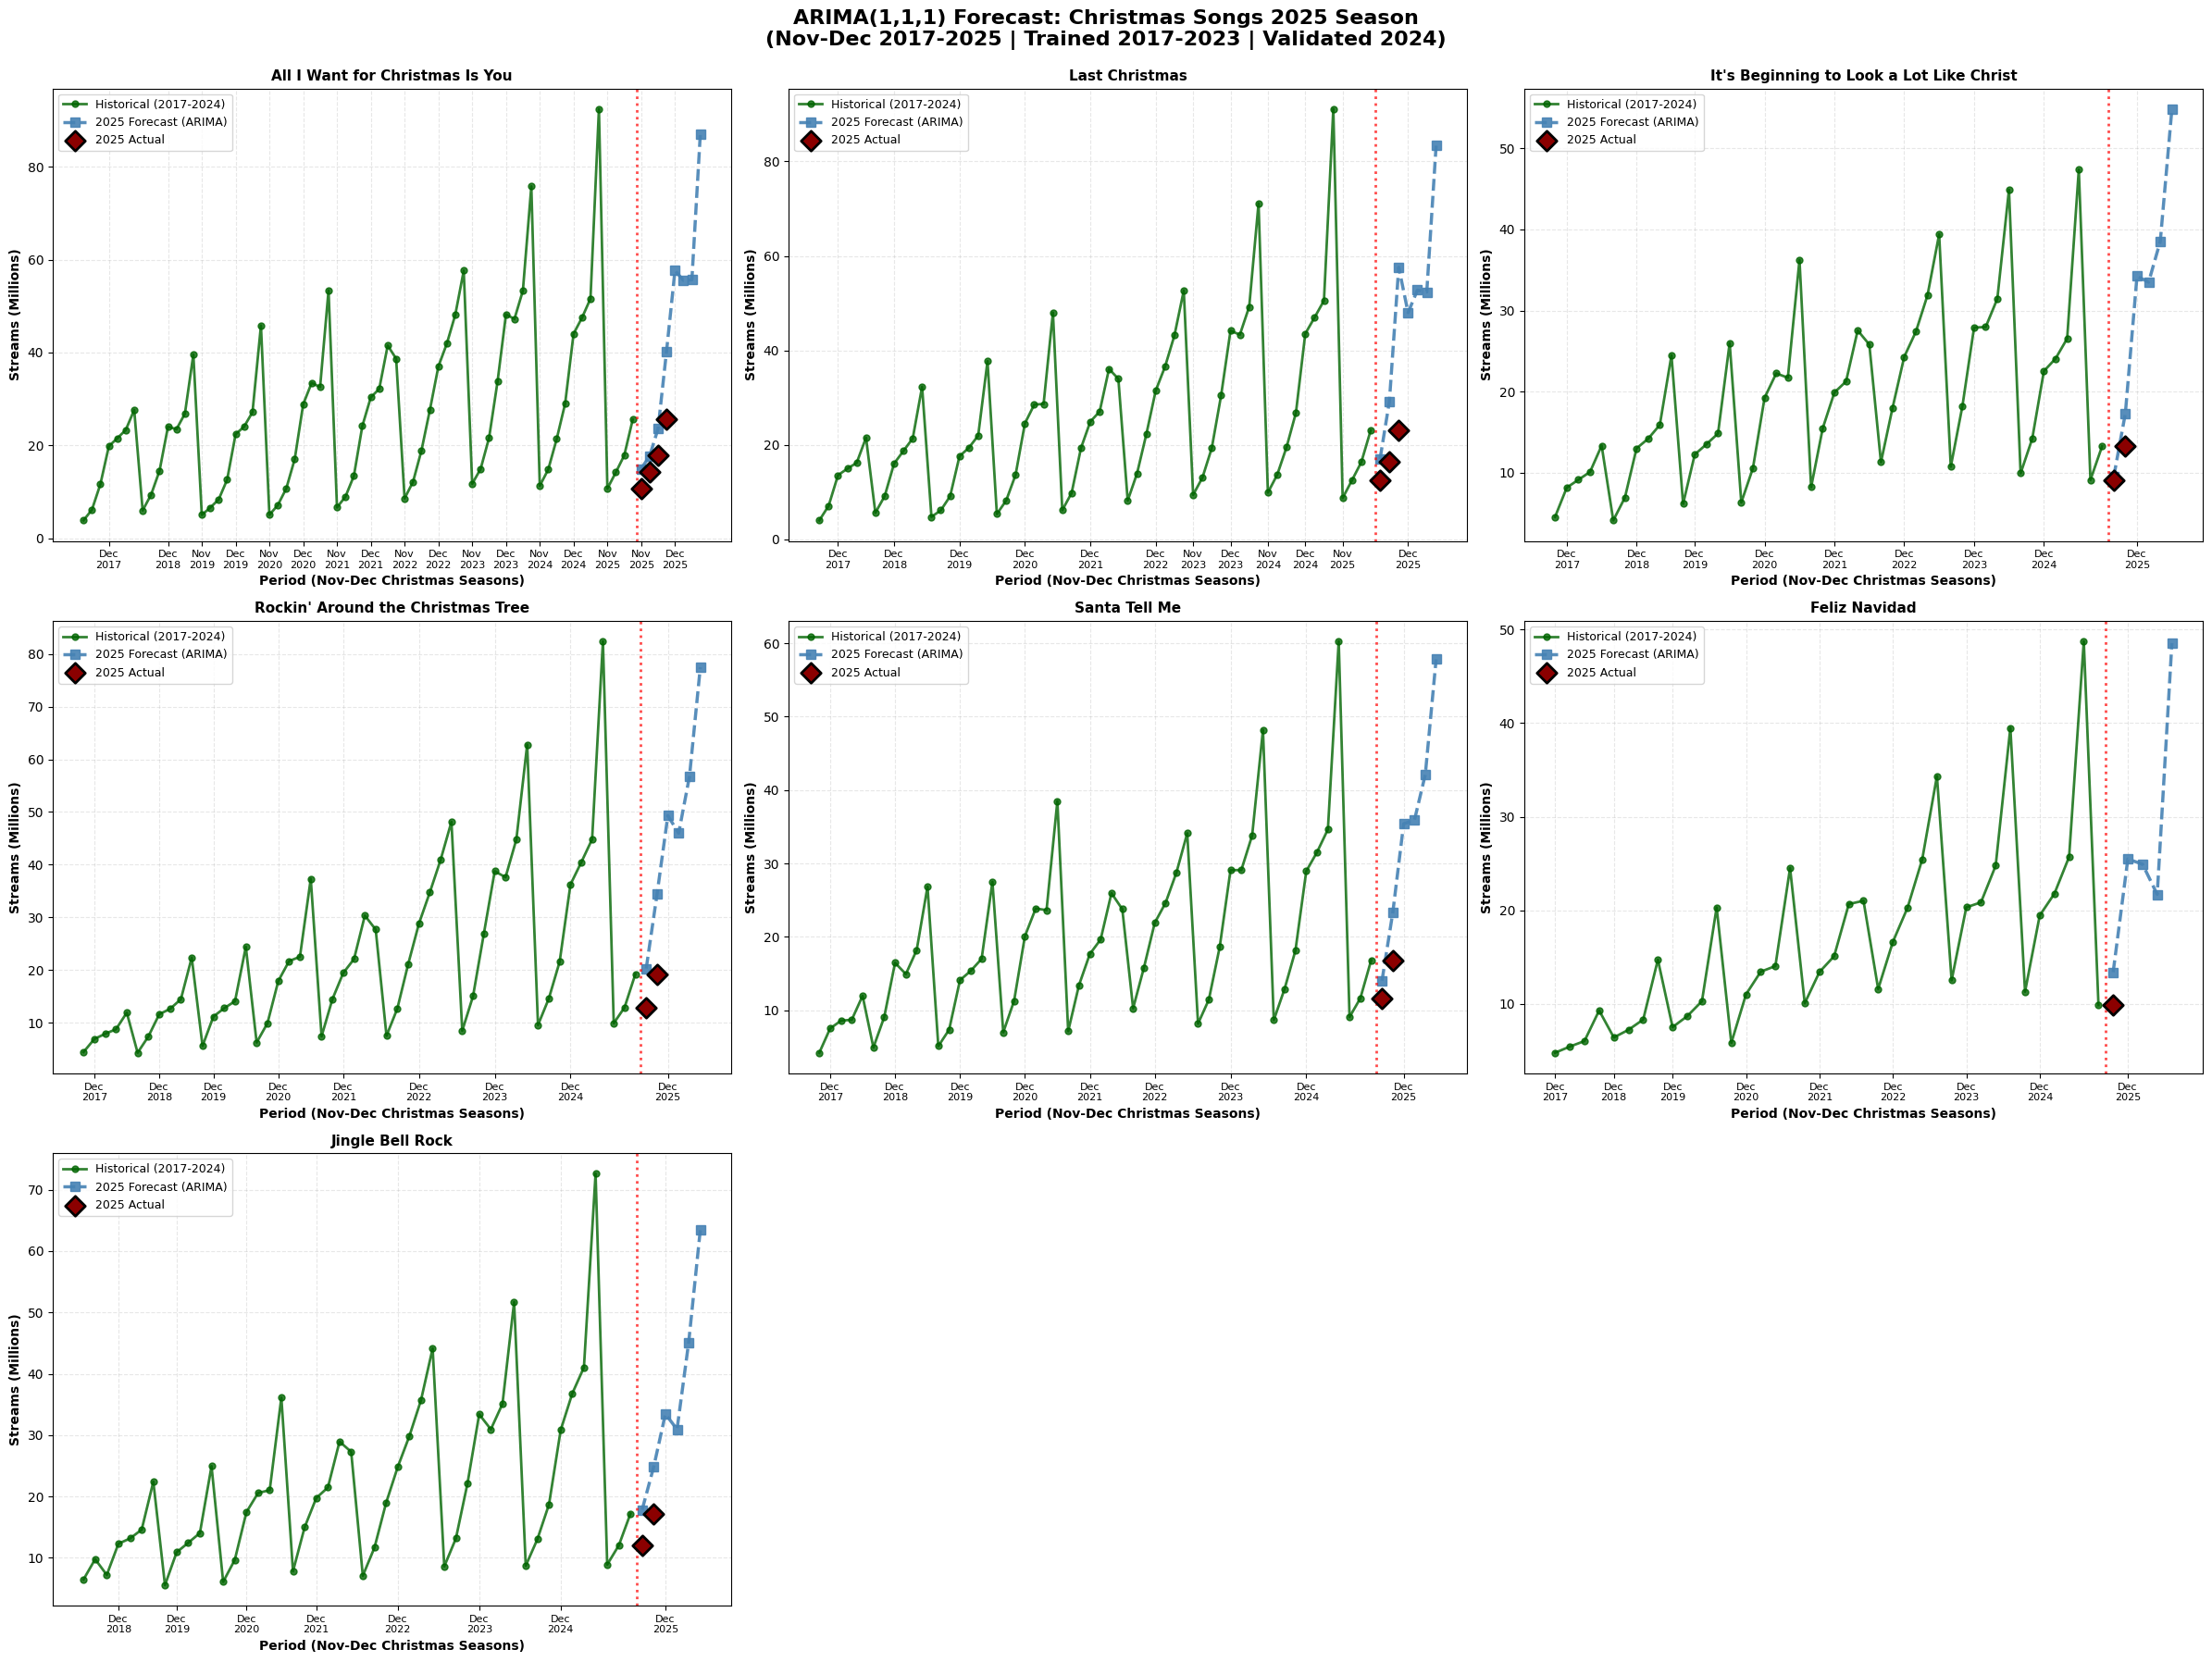

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(24, 18))
axes = axes.flatten() # to 1d, easier manipulation in loops

for idx, song in enumerate(songs):
    if song not in models_per_song or song not in forecasts_2025: #for songs that didn't have forecast
        axes[idx].text(0.5, 0.5, f'{song}\nNo forecast', 
                      ha='center', va='center', fontsize=10)
        axes[idx].axis('off')
        continue

    matrix = matrices_per_song[song]
    forecast_2025 = forecasts_2025[song] #2025 forecast
    validation = validation_2024.get(song, {}) #Validation data
    actual_2025_song = actual_2025[actual_2025['track'] == song].groupby('week_of_year')['streams'].sum() #actual 2025 so far
    #only some weeks in November
    time_series_data = [] #Create continuous time series
    month_markers = []
    month_labels = []
    position = 0
    # Historical data (2017-2024)
    for year in sorted(matrix.index):
        for week in range(45, 53):
            if week in matrix.columns and not pd.isna(matrix.loc[year, week]):
                time_series_data.append(matrix.loc[year, week] / 1e6) #data in millions
                if week == 45:#November start
                    month_markers.append(position)
                    month_labels.append(f'Nov\n{year}') 
                elif week == 49: #December start
                    month_markers.append(position)
                    month_labels.append(f'Dec\n{year}')
                position += 1 

    # 2025 Forecast
    forecast_data = []
    for week in range(45, 53):
        if week in forecast_2025:
            forecast_data.append(forecast_2025[week] / 1e6)
            if week == 45:
                month_markers.append(position)
                month_labels.append(f'Nov\n2025')
            elif week == 49:
                month_markers.append(position)
                month_labels.append(f'Dec\n2025')
            position += 1

    # Plot
    x_hist = range(len(time_series_data))
    axes[idx].plot(x_hist, time_series_data, marker='o', linewidth=2, markersize=5,
                  color='darkgreen', alpha=0.8, label='Historical (2017-2024)')

    x_forecast = range(len(time_series_data), len(time_series_data) + len(forecast_data))
    axes[idx].plot(x_forecast, forecast_data, marker='s', linewidth=2.5, markersize=7,
                  color='steelblue', linestyle='--', alpha=0.9, label='2025 Forecast (ARIMA)')

    #Actual 2025 data (if exists)
    if len(actual_2025_song) > 0:
        actual_x = []
        actual_y = []
        for week in actual_2025_song.index:
            if week in forecast_2025.index:
                pos = len(time_series_data) + list(forecast_2025.index).index(week)
                actual_x.append(pos)
                actual_y.append(actual_2025_song[week] / 1e6)
        if actual_x:
            axes[idx].scatter(actual_x, actual_y, marker='D', s=120, color='darkred', #mark actual data with an x (already released in November)
                            edgecolors='black', linewidths=2, zorder=5, label='2025 Actual')
    axes[idx].axvline(x=len(time_series_data)-0.5, color='red', linestyle=':',     #Dividing line between actual and predicted
                     linewidth=2, alpha=0.7)
    
    # Formatting
    axes[idx].set_xlabel('Period (Nov-Dec Christmas Seasons)', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Streams (Millions)', fontsize=10, fontweight='bold')
    axes[idx].set_title(f'{song[:40]}', fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, linestyle='--')
    axes[idx].legend(fontsize=9, loc='upper left')
    axes[idx].set_xticks(month_markers)
    axes[idx].set_xticklabels(month_labels, fontsize=8)

for idx in range(len(songs), len(axes)):
    axes[idx].axis('off')

plt.suptitle('ARIMA(1,1,1) Forecast: Christmas Songs 2025 Season\n(Nov-Dec 2017-2025 | Trained 2017-2023 | Validated 2024)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

 -Comparing predicted results for 2025 for each song to what actually happened in 2024:

In [15]:
print("2025 FORECAST SUMMARY - Comparison by Song")

summary_data = []
for song in songs: #for each song
    if song not in models_per_song or song not in forecasts_2025:
        continue
    matrix = matrices_per_song[song]  #information for each song
    forecast_2025_series = forecasts_2025[song] #2025 forecast series
    total_2024 = 0
    if 2024 in matrix.index: 
        for week in range(45, 53): #for each week in 2024
            if week in matrix.columns and not pd.isna(matrix.loc[2024, week]):
                total_2024 += matrix.loc[2024, week] #sum all streams for each week in 2024
    total_2025_forecast = forecast_2025_series.sum()  #total sum for 2025 forecast
    absolute_diff = total_2025_forecast - total_2024 #difference between actual 2024 and predicted 2025
    percent_diff = (absolute_diff / total_2024 * 100) if total_2024 > 0 else 0 #error in percentage
    summary_data.append({ #information to be shown in table
        'Song': song[:40], # add the song being analyzed in the loop
        '2024 Actual (M)': f"{total_2024/1e6:.2f}", #actual value in 2024 total sum
        '2025 Predicted (M)': f"{total_2025_forecast/1e6:.2f}", #predicted sum for 2025
        'Difference (M)': f"{absolute_diff/1e6:+.2f}", # absolute difference between the two
        'Variation %': f"{percent_diff:+.1f}%" #difference in percentage 
    }) 

summary_df = pd.DataFrame(summary_data) #transform above data into DataFrame for easier visualization
print(summary_df.to_string(index=False))  #display DataFrame without index

2025 FORECAST SUMMARY - Comparison by Song
                                    Song 2024 Actual (M) 2025 Predicted (M) Difference (M) Variation %
         All I Want for Christmas Is You          312.13             352.55         +40.42      +12.9%
                          Last Christmas          302.18             340.29         +38.10      +12.6%
It's Beginning to Look a Lot Like Christ          144.67             187.91         +43.24      +29.9%
       Rockin' Around the Christmas Tree          249.65             284.24         +34.59      +13.9%
                           Santa Tell Me          195.18             208.63         +13.46       +6.9%
                           Feliz Navidad          126.98             134.05          +7.07       +5.6%
                        Jingle Bell Rock          221.78             215.73          -6.06       -2.7%


Analyzing the 2025 forecast results, a generalized growth is observed in 6 of the 7 Christmas songs, with special emphasis on "It's Beginning to Look a Lot Like Christmas" which shows the largest jump (+29.9%), indicating an accelerated popularization trend, while the leaders "All I Want for Christmas Is You" and "Last Christmas" consolidate their dominance with forecasts above 340 million streams each (~13% growth), whereas already established songs like "Feliz Navidad" and "Santa Tell Me" show more modest growth (5-7%), and only "Jingle Bell Rock" shows decline (-2.7%), suggesting possible saturation, which reveals a market dynamic where classics remain strong but with different growth trajectories as public engagement evolves.

# 4. Linear Regression Model: Alternative Approach

-------------

## Why Linear Regression May Be More Appropriate

After analyzing the ARIMA implementation, several issues suggest that **Linear Regression** might be a better fit for this dataset:

### Problems with ARIMA(1,1,1):
1. **Convergence Warnings**: Multiple `ConvergenceWarning` messages indicate the model struggles to fit properly
2. **Artificial Time Series**: We're creating series of only ~8 points (years 2017-2024) per week - not a true sequential time series
3. **Over-parameterization**: ARIMA(1,1,1) has 3-4 parameters competing for only 6-7 points after differencing
4. **Questionable Autocorrelation**: The MA(1) component (moving average of errors) is questionable with so few points
5. **Unnecessary Differencing**: The d=1 parameter reduces the already small dataset further

### Advantages of Linear Regression:
1. **Simple Trend Modeling**: We're essentially modeling **year-over-year growth trend** - exactly what linear regression does
2. **Fewer Parameters**: Only 2 parameters (intercept + slope) vs 3-4 for ARIMA
3. **Robust with Small Samples**: Works well even with 8 data points
4. **No Convergence Issues**: Analytical solution via least squares
5. **Easy Interpretation**: "Each year, streams grow by X millions"

### Mathematical Formulation:

**Simple Linear Regression:**
$$\text{streams} = \beta_0 + \beta_1 \times \text{year} + \varepsilon$$

Where:
- $\beta_0$ (intercept): Base level of streams
- $\beta_1$ (slope): Annual growth rate
- $\varepsilon$: Random error

**Optional Polynomial Regression (degree 2)** to capture acceleration:
$$\text{streams} = \beta_0 + \beta_1 \times \text{year} + \beta_2 \times \text{year}^2 + \varepsilon$$

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [17]:
models_per_song_lr = {}  #training with data from 2017 to 2024 for each song
validation_2024_lr = {} #validation with 2024 data
forecasts_2025_lr = {} #forecast for 2025 data
print("\nTraining Linear Regression models per week per song...")

for song in songs: #for each song
    matrix = matrices_per_song[song] #the matrix of total sum per week in year for each song
    song_models = {} 
    validation_results = {} #Validation results
    forecast_values = {} #forecast results
    for week in range(45, 53): #for each week of Christmas season
        if week in matrix.columns:
            week_series = matrix[week].dropna() #remove weeks without data for all songs (Some songs are not in top 200 at the beginning of season)
            if len(week_series) >= 5: # check if there are more than 5 week data points for analysis
                train_series = week_series[week_series.index <= 2023] #training data, being non-null week data (47 - 53) up to 2023
                
                X_train = train_series.index.values.reshape(-1, 1) #years as features (independent variable)
                y_train = train_series.values #streams as target (dependent variable)
                
                try:
                    model = LinearRegression() #Train Linear Regression model
                    model.fit(X_train, y_train) #Fit model
                    song_models[week] = model
                    if 2024 in week_series.index:
                        pred_2024 = model.predict([[2024]])[0] #Validation for 2024 data, it will try to predict 2024 week data for each song to validate the model
                        actual_2024 = week_series[2024] #the actual values of each week in 2024
                        error_pct = abs(pred_2024 - actual_2024) / actual_2024 * 100 #calculate error being (predicted - actual)/predicted
                        validation_results[week] = { #store results per week of 2024
                            'predicted': pred_2024, #predicted values
                            'actual': actual_2024, #actual values
                            'error_pct': error_pct #error
                        }
                    pred_2025 = model.predict([[2025]])[0] # Forecast for 2025
                    forecast_values[week] = pred_2025 #predict models for 2025.

                except Exception as e:
                    print(f"  Error in {song} week {week}: {e}")
                    continue

    # Save results
    if song_models:
        models_per_song_lr[song] = song_models
    if validation_results:
        validation_2024_lr[song] = validation_results
    if forecast_values:
        forecasts_2025_lr[song] = pd.Series(forecast_values)

print("Linear Regression training complete!")


Training Linear Regression models per week per song...
Linear Regression training complete!


In [18]:
print("VALIDATION - 2024 (Linear Regression)")
for song in songs: #for all songs
    if song in validation_2024_lr and validation_2024_lr[song]: #only enters this loop if the song trained up to 2023 had validation data in 2024
        #it may be that the song didn't have enough data in 2024
        errors = [v['error_pct'] for v in validation_2024_lr[song].values()] #Get percentage error in all valid weeks of 2024
        mape = np.mean(errors) #mean of errors
        print(f"{song[:40]:40s} | MAPE = {mape:6.1f}%")

VALIDATION - 2024 (Linear Regression)
All I Want for Christmas Is You          | MAPE =   10.6%
Last Christmas                           | MAPE =    7.9%
It's Beginning to Look a Lot Like Christ | MAPE =   32.6%
Rockin' Around the Christmas Tree        | MAPE =   14.4%
Santa Tell Me                            | MAPE =    7.8%
Feliz Navidad                            | MAPE =   18.1%
Jingle Bell Rock                         | MAPE =   16.7%


- to visualize the error of each week

In [19]:
print("VALIDATION - 2024 - error analysis (Linear Regression)")
for song in songs:
    if song in validation_2024_lr and validation_2024_lr[song]:
        print(f"\n{song}")
        print("Week | Error (%)")
        print("-" * 20)
        for week, v in validation_2024_lr[song].items(): #returns key and value for each song, week and error
            #45: {'error_pct': 12.3}
            print(f"{week:>6} | {v['error_pct']:6.1f}%")

VALIDATION - 2024 - error analysis (Linear Regression)

All I Want for Christmas Is You
Week | Error (%)
--------------------
    45 |   10.6%
    46 |    3.8%
    47 |    6.5%
    48 |   21.0%
    49 |    7.0%
    50 |    4.0%
    51 |   10.7%
    52 |   20.9%

Last Christmas
Week | Error (%)
--------------------
    46 |    2.4%
    47 |    2.3%
    48 |   16.2%
    49 |    0.8%
    50 |    3.6%
    51 |    5.6%
    52 |   24.2%

It's Beginning to Look a Lot Like Christmas
Week | Error (%)
--------------------
    47 |   30.4%
    48 |   53.3%
    49 |   35.8%
    50 |   34.3%
    51 |   41.1%
    52 |    0.9%

Rockin' Around the Christmas Tree
Week | Error (%)
--------------------
    47 |   11.3%
    48 |   28.2%
    49 |    7.6%
    50 |    3.1%
    51 |   12.6%
    52 |   23.3%

Santa Tell Me
Week | Error (%)
--------------------
    47 |    3.4%
    48 |   12.2%
    49 |    1.7%
    50 |    0.2%
    51 |    7.8%
    52 |   21.7%

Feliz Navidad
Week | Error (%)
------------------

- Plotting validation and training data and comparing error each week

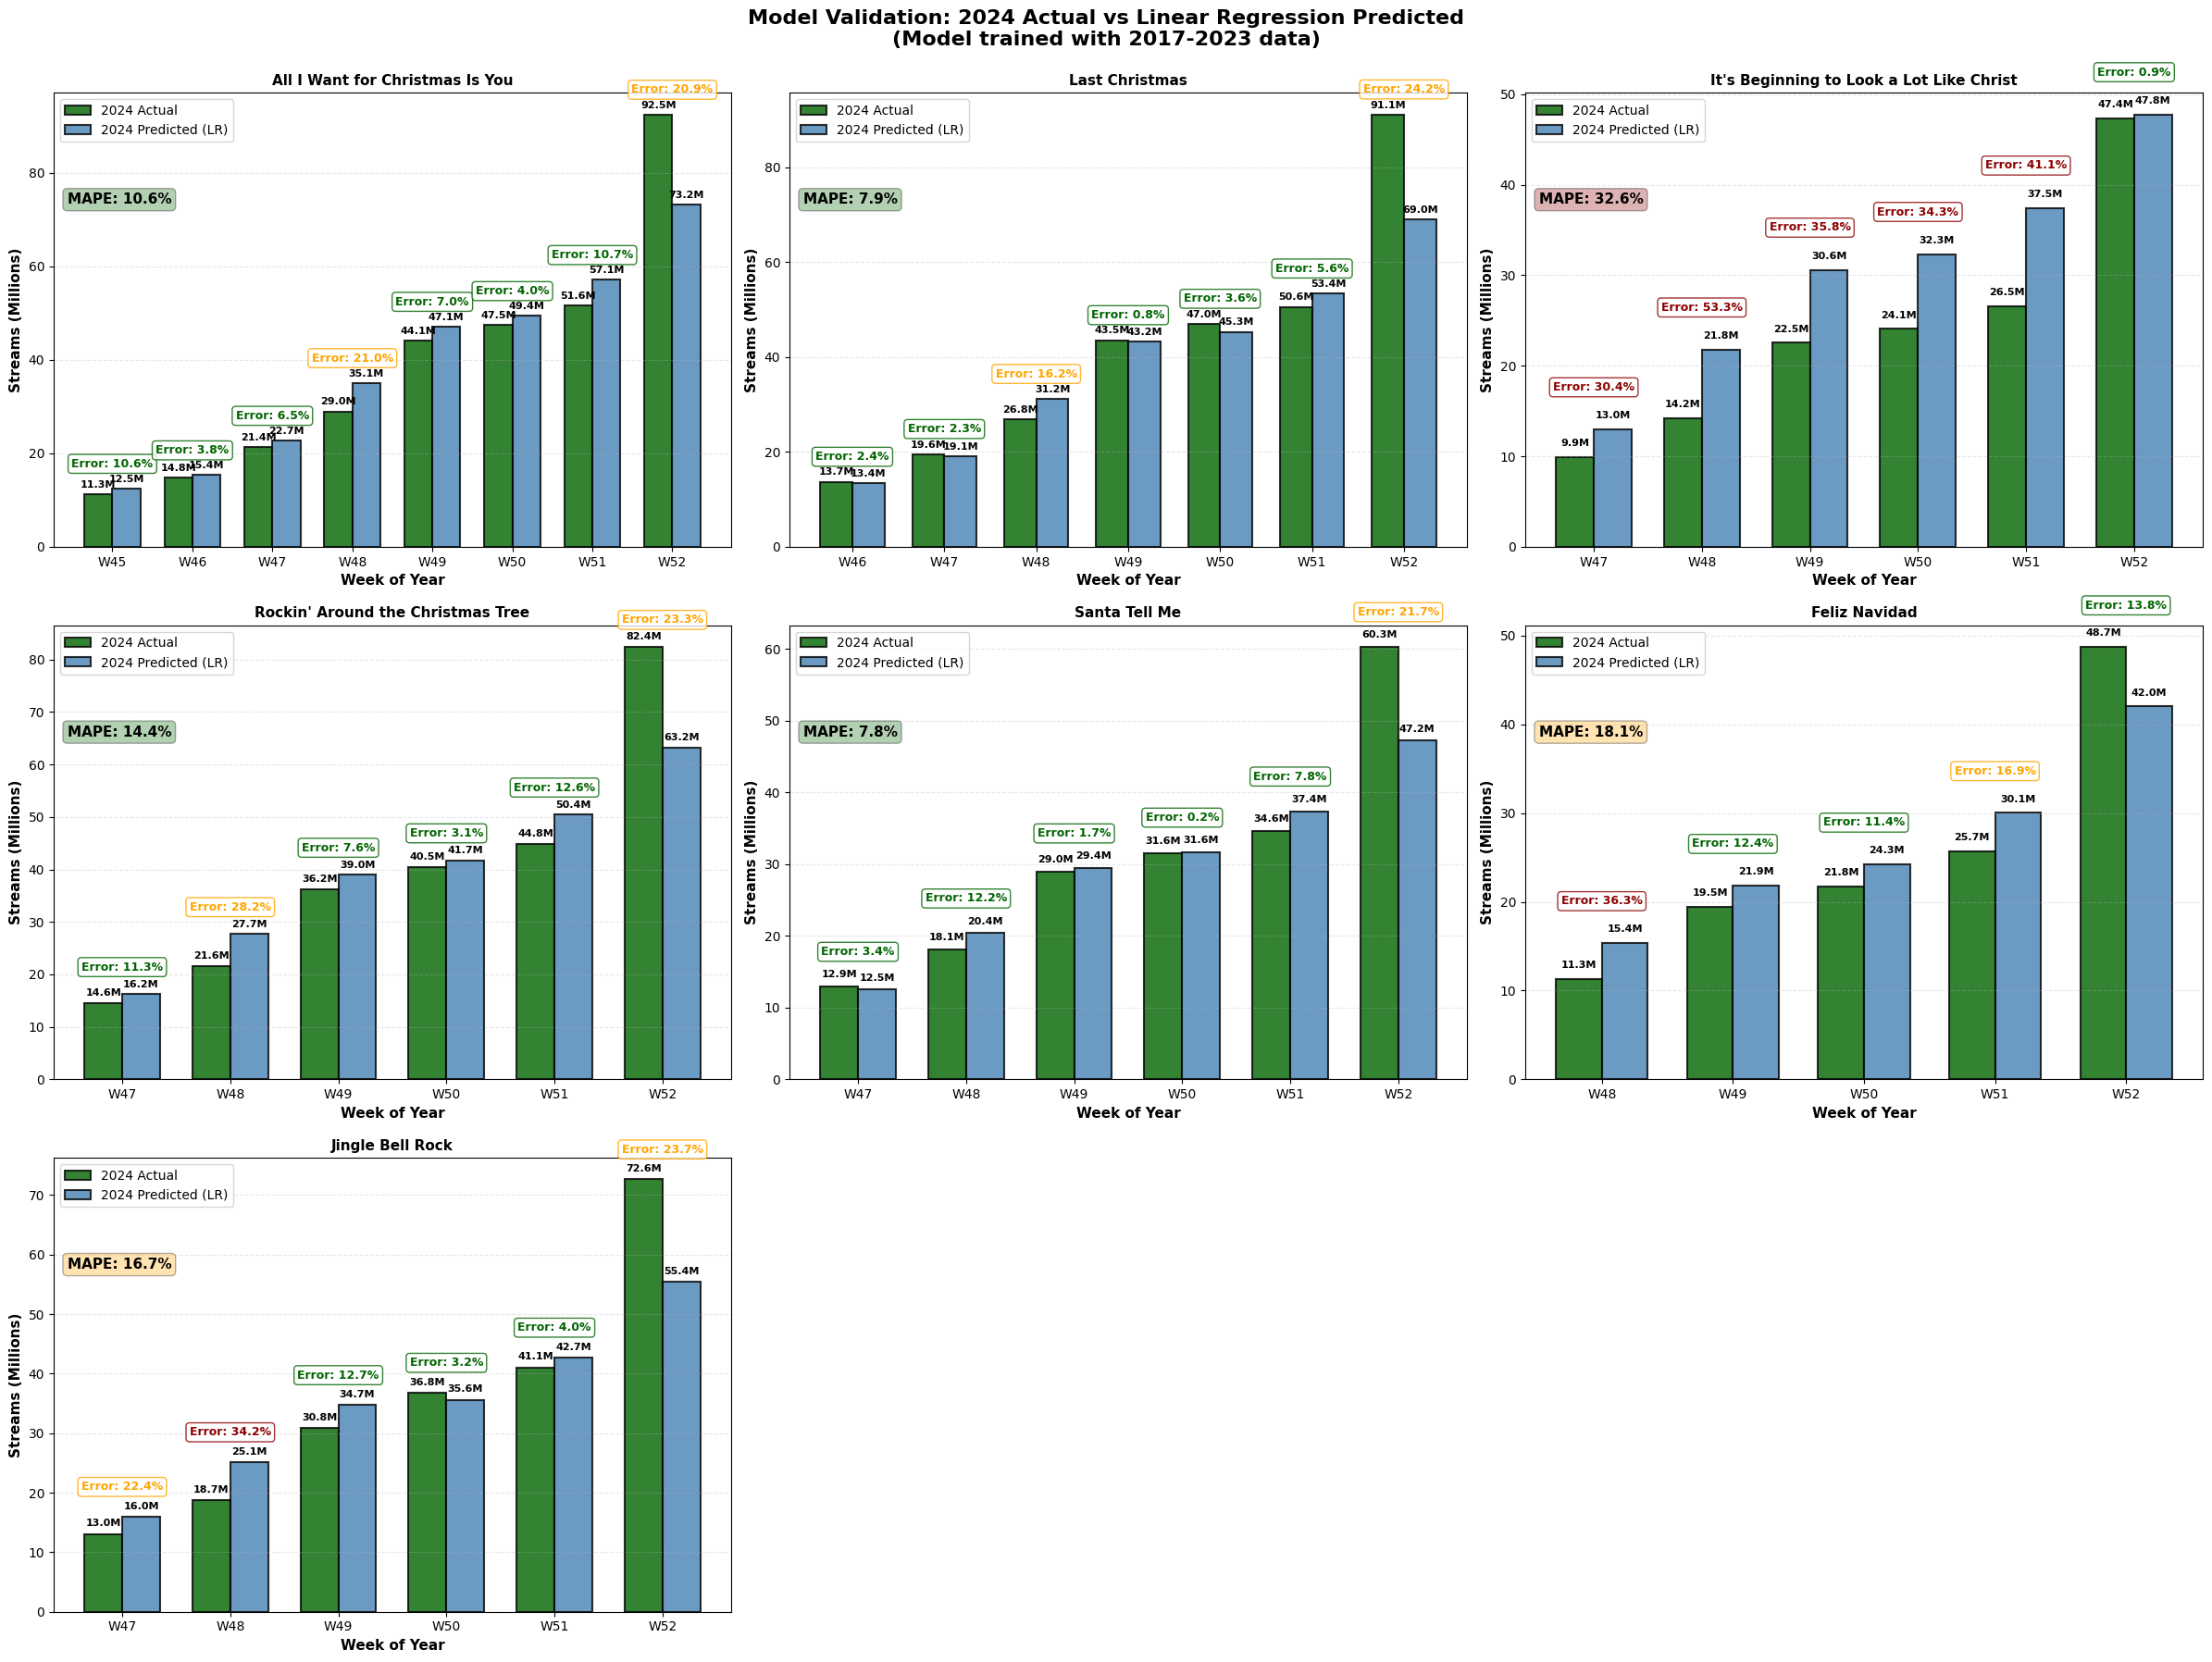

In [20]:

# CHART: VALIDATION 2024 (Actual vs Predicted) - Linear Regression

fig, axes = plt.subplots(3, 3, figsize=(24, 18))
axes = axes.flatten()

for idx, song in enumerate(songs): #for each song
    if song not in validation_2024_lr or not validation_2024_lr[song]: #check if validation analysis was done
        axes[idx].text(0.5, 0.5, f'{song}\nNo validation data',  
                      ha='center', va='center', fontsize=10)
        axes[idx].axis('off')
        continue
    
    validation = validation_2024_lr[song] #validation data for each week of 2024 for each song 
    weeks = sorted(validation.keys()) #sort weeks
    actual_values = [validation[w]['actual'] / 1e6 for w in weeks] #actual values of 2024 (the real ones), and convert to millions
    predicted_values = [validation[w]['predicted'] / 1e6 for w in weeks] #predicted values 
    errors = [validation[w]['error_pct'] for w in weeks] #error for each week
    
    # Bar chart
    x = np.arange(len(weeks))
    width = 0.35
    bars1 = axes[idx].bar(x - width/2, actual_values, width,  #bar chart with actual values in green color
                          label='2024 Actual', color='darkgreen', alpha=0.8, 
                          edgecolor='black', linewidth=1.5)
    bars2 = axes[idx].bar(x + width/2, predicted_values, width, 
                          label='2024 Predicted (LR)', color='steelblue', alpha=0.8,  #bar chart with blue color for predicted
                          edgecolor='black', linewidth=1.5)
    
    # Add stream values on bars
    for i, (actual, pred) in enumerate(zip(actual_values, predicted_values)):
        axes[idx].text(i - width/2, actual + 1, f'{actual:.1f}M', 
                      ha='center', va='bottom', fontsize=8, fontweight='bold')
        axes[idx].text(i + width/2, pred + 1, f'{pred:.1f}M',
                      ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    #Add % error
    for i, error in enumerate(errors):
        max_val = max(actual_values[i], predicted_values[i])
        error_color = 'darkgreen' if error < 15 else 'orange' if error < 30 else 'darkred'
        axes[idx].text(i, max_val + 4, f'Error: {error:.1f}%',
                      ha='center', va='bottom', fontsize=9, fontweight='bold',
                      color=error_color,
                      bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                               edgecolor=error_color, alpha=0.8))
    
    # Formatting
    axes[idx].set_xlabel('Week of Year', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Streams (Millions)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{song[:40]}', fontsize=11, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels([f'W{w}' for w in weeks], fontsize=10)
    axes[idx].legend(fontsize=10, loc='upper left')
    axes[idx].grid(True, alpha=0.3, linestyle='--', axis='y')
    # MAPE ->  mean error (all errors divided by number of weeks)
    mape = np.mean(errors)
    mape_color = 'darkgreen' if mape < 15 else 'orange' if mape < 30 else 'darkred'
    axes[idx].text(0.02, 0.78, f'MAPE: {mape:.1f}%',
                  transform=axes[idx].transAxes, fontsize=11, fontweight='bold',
                  verticalalignment='top', horizontalalignment='left',
                  bbox=dict(boxstyle='round', facecolor=mape_color, 
                           edgecolor='black', alpha=0.3))

for idx in range(len(songs), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Model Validation: 2024 Actual vs Linear Regression Predicted\n(Model trained with 2017-2023 data)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

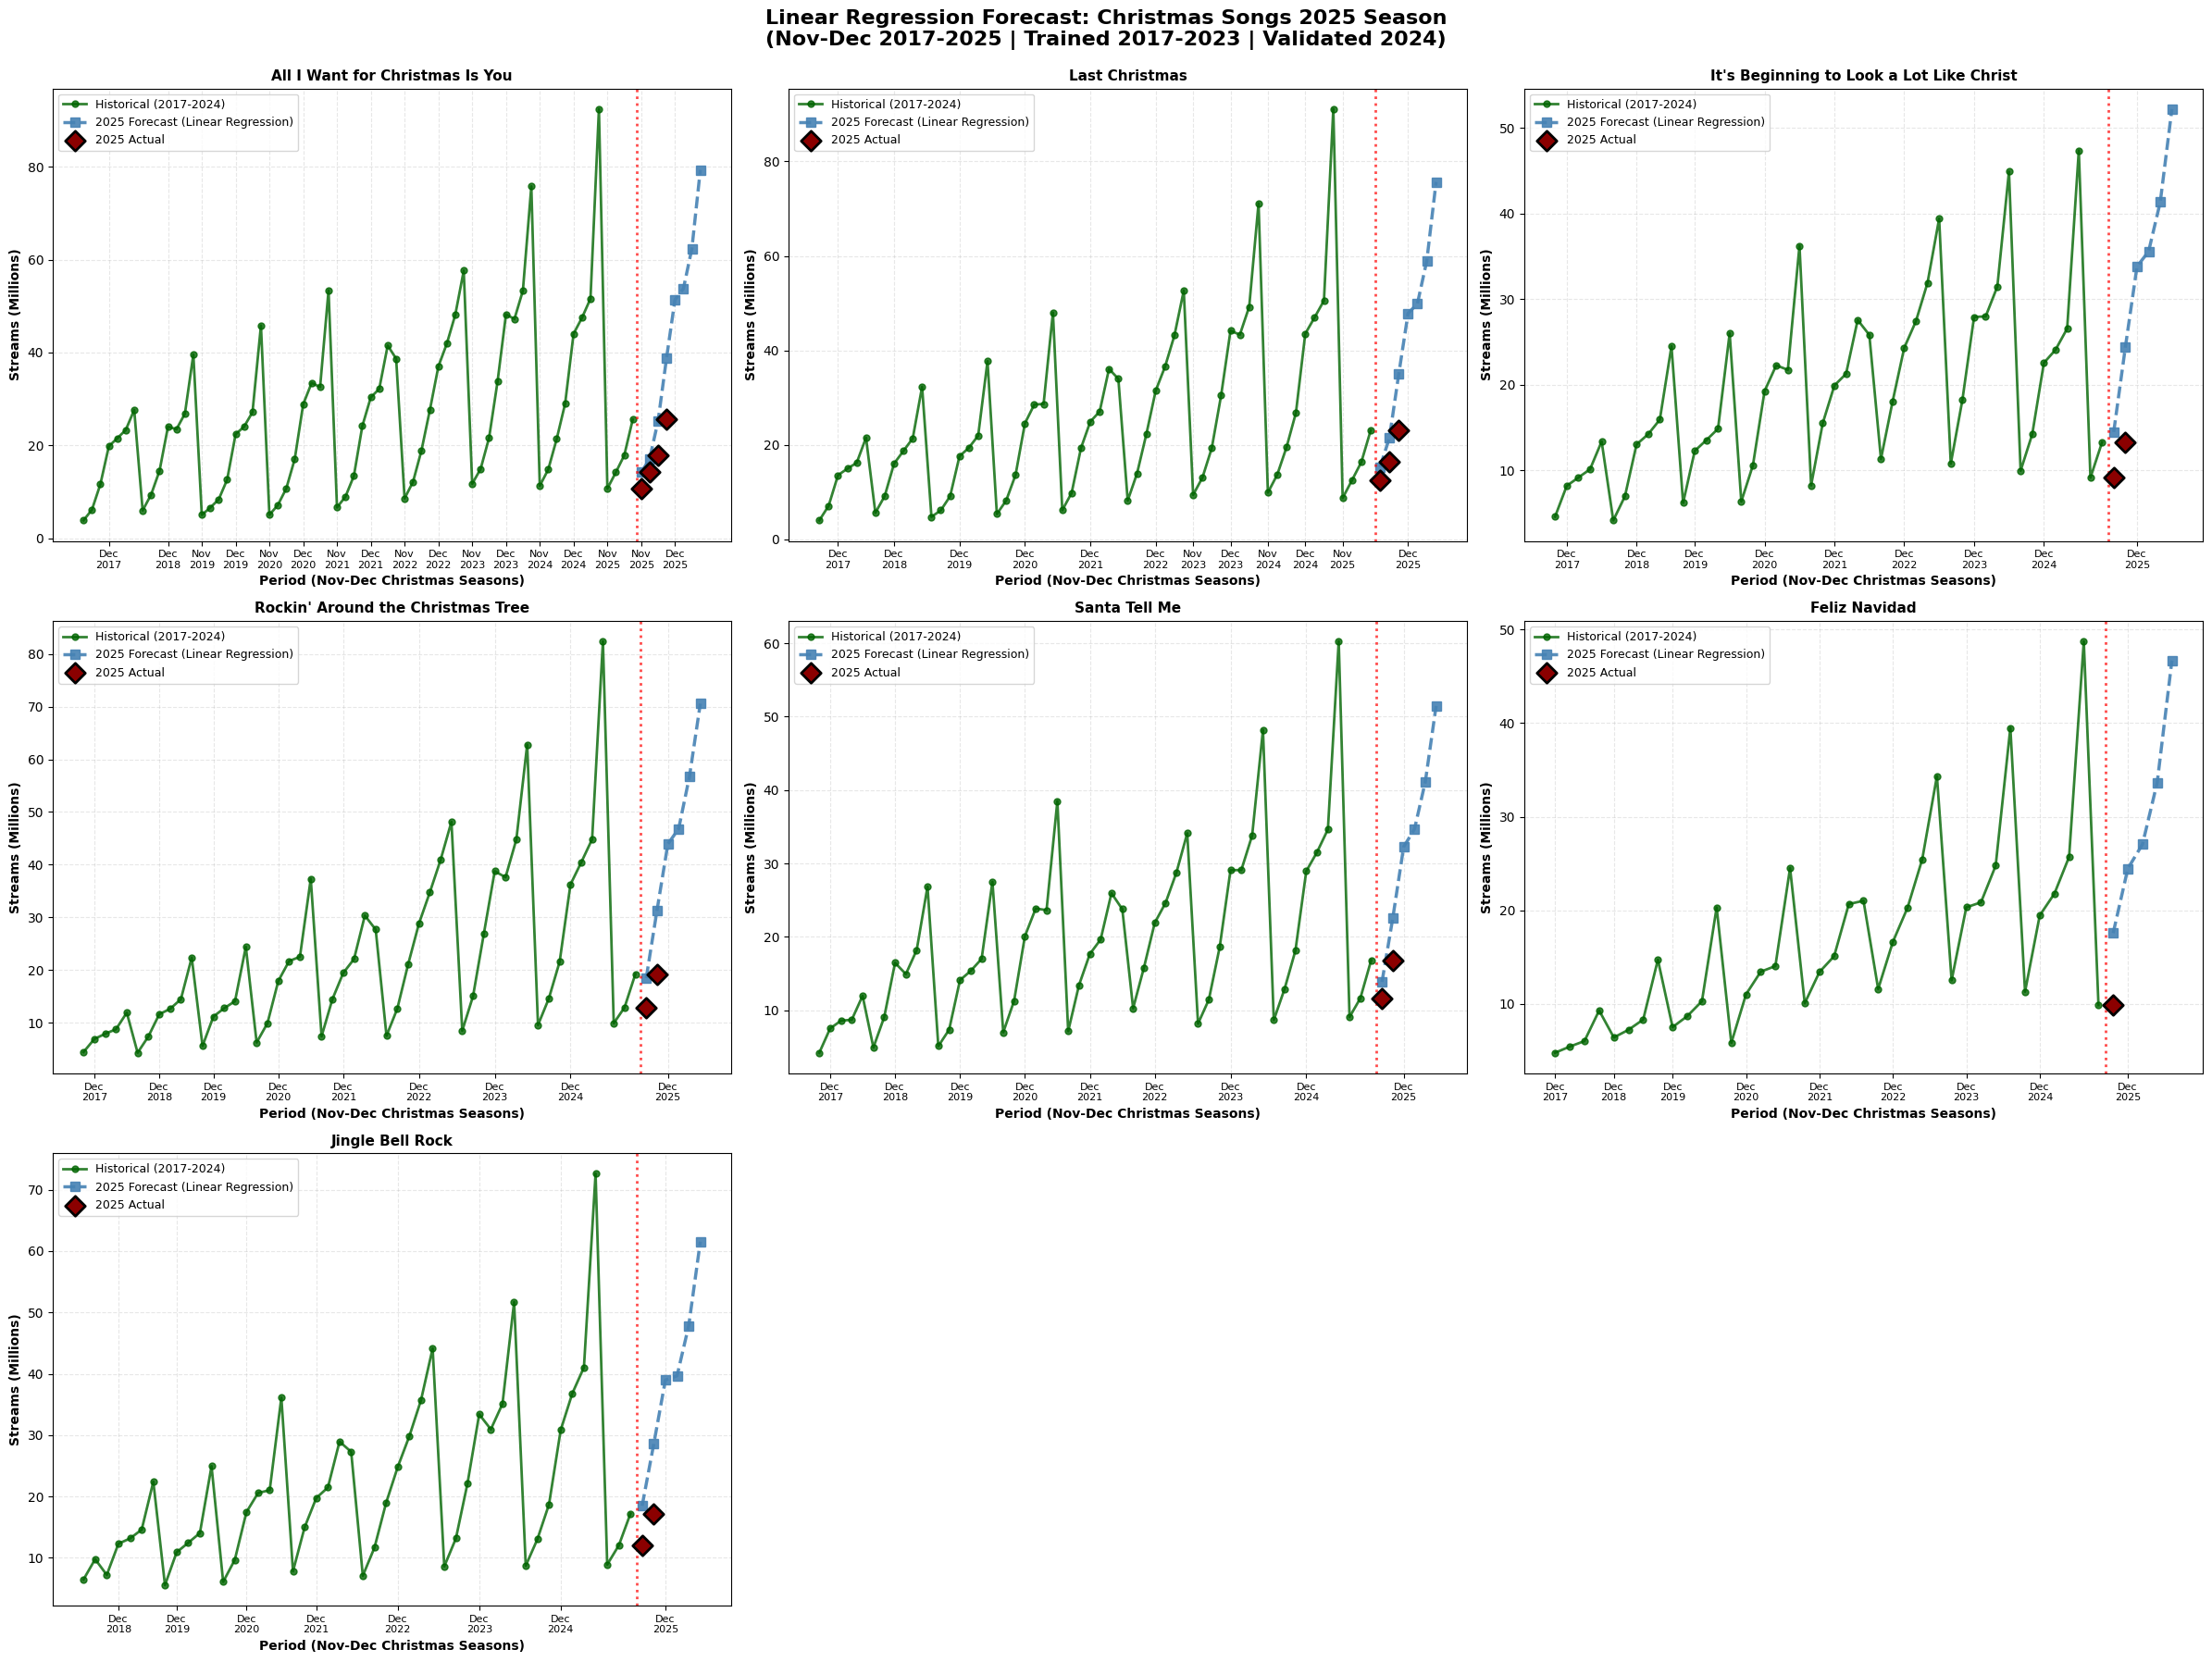

In [21]:
# CHART: TIME SERIES FORECAST 2017-2025 (Linear Regression)

fig, axes = plt.subplots(3, 3, figsize=(24, 18))
axes = axes.flatten() # to 1d, easier manipulation in loops

for idx, song in enumerate(songs):
    if song not in models_per_song_lr or song not in forecasts_2025_lr: #for songs that didn't have forecast
        axes[idx].text(0.5, 0.5, f'{song}\nNo forecast', 
                      ha='center', va='center', fontsize=10)
        axes[idx].axis('off')
        continue

    matrix = matrices_per_song[song]
    forecast_2025 = forecasts_2025_lr[song] #2025 forecast (Linear Regression)
    validation = validation_2024_lr.get(song, {}) #Validation data
    actual_2025_song = actual_2025[actual_2025['track'] == song].groupby('week_of_year')['streams'].sum() #actual 2025 so far
    #only some weeks in November
    time_series_data = [] #Create continuous time series
    month_markers = []
    month_labels = []
    position = 0
    # Historical data (2017-2024)
    for year in sorted(matrix.index):
        for week in range(45, 53):
            if week in matrix.columns and not pd.isna(matrix.loc[year, week]):
                time_series_data.append(matrix.loc[year, week] / 1e6) #data in millions
                if week == 45:#November start
                    month_markers.append(position)
                    month_labels.append(f'Nov\n{year}') 
                elif week == 49: #December start
                    month_markers.append(position)
                    month_labels.append(f'Dec\n{year}')
                position += 1 

    # 2025 Forecast
    forecast_data = []
    for week in range(45, 53):
        if week in forecast_2025:
            forecast_data.append(forecast_2025[week] / 1e6)
            if week == 45:
                month_markers.append(position)
                month_labels.append(f'Nov\n2025')
            elif week == 49:
                month_markers.append(position)
                month_labels.append(f'Dec\n2025')
            position += 1

    # Plot
    x_hist = range(len(time_series_data))
    axes[idx].plot(x_hist, time_series_data, marker='o', linewidth=2, markersize=5,
                  color='darkgreen', alpha=0.8, label='Historical (2017-2024)')

    x_forecast = range(len(time_series_data), len(time_series_data) + len(forecast_data))
    axes[idx].plot(x_forecast, forecast_data, marker='s', linewidth=2.5, markersize=7,
                  color='steelblue', linestyle='--', alpha=0.9, label='2025 Forecast (Linear Regression)')

    #Actual 2025 data (if exists)
    if len(actual_2025_song) > 0:
        actual_x = []
        actual_y = []
        for week in actual_2025_song.index:
            if week in forecast_2025.index:
                pos = len(time_series_data) + list(forecast_2025.index).index(week)
                actual_x.append(pos)
                actual_y.append(actual_2025_song[week] / 1e6)
        if actual_x:
            axes[idx].scatter(actual_x, actual_y, marker='D', s=120, color='darkred', #mark actual data with an x (already released in November)
                            edgecolors='black', linewidths=2, zorder=5, label='2025 Actual')
    axes[idx].axvline(x=len(time_series_data)-0.5, color='red', linestyle=':',     #Dividing line between actual and predicted
                     linewidth=2, alpha=0.7)
    
    # Formatting
    axes[idx].set_xlabel('Period (Nov-Dec Christmas Seasons)', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Streams (Millions)', fontsize=10, fontweight='bold')
    axes[idx].set_title(f'{song[:40]}', fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, linestyle='--')
    axes[idx].legend(fontsize=9, loc='upper left')
    axes[idx].set_xticks(month_markers)
    axes[idx].set_xticklabels(month_labels, fontsize=8)

for idx in range(len(songs), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Linear Regression Forecast: Christmas Songs 2025 Season\n(Nov-Dec 2017-2025 | Trained 2017-2023 | Validated 2024)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

 -Comparing predicted results for 2025 for each song to what actually happened in 2024:

In [22]:
print("2025 FORECAST SUMMARY - Comparison by Song (Linear Regression)")

summary_data_lr = []
for song in songs: #for each song
    if song not in models_per_song_lr or song not in forecasts_2025_lr:
        continue
    matrix = matrices_per_song[song]  #information for each song
    forecast_2025_series = forecasts_2025_lr[song] #2025 forecast series
    total_2024 = 0
    if 2024 in matrix.index: 
        for week in range(45, 53): #for each week in 2024
            if week in matrix.columns and not pd.isna(matrix.loc[2024, week]):
                total_2024 += matrix.loc[2024, week] #sum all streams for each week in 2024
    total_2025_forecast = forecast_2025_series.sum()  #total sum for 2025 forecast
    absolute_diff = total_2025_forecast - total_2024 #difference between actual 2024 and predicted 2025
    percent_diff = (absolute_diff / total_2024 * 100) if total_2024 > 0 else 0 #error in percentage
    summary_data_lr.append({ #information to be shown in table
        'Song': song[:40], # add the song being analyzed in the loop
        '2024 Actual (M)': f"{total_2024/1e6:.2f}", #actual value in 2024 total sum
        '2025 Predicted (M)': f"{total_2025_forecast/1e6:.2f}", #predicted sum for 2025
        'Difference (M)': f"{absolute_diff/1e6:+.2f}", # absolute difference between the two
        'Variation %': f"{percent_diff:+.1f}%" #difference in percentage 
    }) 

summary_df_lr = pd.DataFrame(summary_data_lr) #transform above data into DataFrame for easier visualization
print(summary_df_lr.to_string(index=False))  #display DataFrame without index

2025 FORECAST SUMMARY - Comparison by Song (Linear Regression)
                                    Song 2024 Actual (M) 2025 Predicted (M) Difference (M) Variation %
         All I Want for Christmas Is You          312.13             342.24         +30.12       +9.6%
                          Last Christmas          302.18             304.14          +1.96       +0.6%
It's Beginning to Look a Lot Like Christ          144.67             201.73         +57.06      +39.4%
       Rockin' Around the Christmas Tree          249.65             267.93         +18.28       +7.3%
                           Santa Tell Me          195.18             195.99          +0.82       +0.4%
                           Feliz Navidad          126.98             149.44         +22.46      +17.7%
                        Jingle Bell Rock          221.78             235.07         +13.28       +6.0%


# 5. Model Comparison: ARIMA vs Linear Regression

-------------

## 5.1 Validation Error Comparison (MAPE - 2024)

---------

In [ ]:
# Compare MAPE between ARIMA and Linear Regression
print("=" * 80)
print("VALIDATION ERROR COMPARISON - MAPE 2024")
print("=" * 80)
print(f"{'Song':<40} {'ARIMA MAPE':>12} {'LR MAPE':>12} {'Difference':>12} {'Winner':>10}")
print("-" * 80)

comparison_data = []
for song in songs: #for each song
    if song in validation_2024 and song in validation_2024_lr:
        if validation_2024[song] and validation_2024_lr[song]:
            errors_arima = [v['error_pct'] for v in validation_2024[song].values()] #Calculate MAPE for ARIMA
            mape_arima = np.mean(errors_arima)
            
            errors_lr = [v['error_pct'] for v in validation_2024_lr[song].values()] #Calculate MAPE for Linear Regression
            mape_lr = np.mean(errors_lr)
            
            diff = mape_arima - mape_lr  #positive means LR is better
            winner = "LR" if diff > 0 else "ARIMA" if diff < 0 else "TIE"
            
            print(f"{song[:40]:<40} {mape_arima:>11.1f}% {mape_lr:>11.1f}% {diff:>+11.1f}% {winner:>10}")
            
            comparison_data.append({
                'song': song,
                'arima_mape': mape_arima,
                'lr_mape': mape_lr,
                'difference': diff
            })

print("=" * 80)

avg_arima = np.mean([d['arima_mape'] for d in comparison_data]) #Calculate average MAPE across all songs
avg_lr = np.mean([d['lr_mape'] for d in comparison_data])
avg_diff = avg_arima - avg_lr

print(f"\n{'AVERAGE ACROSS ALL SONGS':<40} {avg_arima:>11.1f}% {avg_lr:>11.1f}% {avg_diff:>+11.1f}%")
print(f"\nOverall Winner: {'Linear Regression' if avg_diff > 0 else 'ARIMA' if avg_diff < 0 else 'TIE'}")
print("=" * 80)

## 5.2 Forecast Comparison (2025 Predictions)

-------

In [ ]:
# Compare 2025 forecasts between ARIMA and Linear Regression
print("=" * 95)
print("2025 FORECAST COMPARISON - Total Season Predictions (Millions)")
print("=" * 95)
print(f"{'Song':<40} {'ARIMA':>12} {'Lin. Reg.':>12} {'Difference':>12} {'% Diff':>10}")
print("-" * 95)

forecast_comparison = []
for song in songs: #for each song
    if song in forecasts_2025 and song in forecasts_2025_lr:
        total_arima = forecasts_2025[song].sum() #ARIMA forecast
        
        total_lr = forecasts_2025_lr[song].sum() #Linear Regression forecast
        
        diff = total_lr - total_arima #Calculate difference
        pct_diff = (diff / total_arima * 100) if total_arima > 0 else 0
        
        print(f"{song[:40]:<40} {total_arima/1e6:>11.2f}M {total_lr/1e6:>11.2f}M {diff/1e6:>+11.2f}M {pct_diff:>+9.1f}%")
        
        forecast_comparison.append({
            'song': song,
            'arima': total_arima,
            'lr': total_lr,
            'difference': diff,
            'pct_diff': pct_diff
        })

print("=" * 95)

total_arima_all = sum([d['arima'] for d in forecast_comparison]) #Calculate totals
total_lr_all = sum([d['lr'] for d in forecast_comparison])
total_diff = total_lr_all - total_arima_all
total_pct_diff = (total_diff / total_arima_all * 100) if total_arima_all > 0 else 0

print(f"\n{'TOTAL ALL SONGS':<40} {total_arima_all/1e6:>11.2f}M {total_lr_all/1e6:>11.2f}M {total_diff/1e6:>+11.2f}M {total_pct_diff:>+9.1f}%")
print("=" * 95)

## 5.3 Visual Comparison

--------

In [ ]:
# Visual comparison: MAPE by song
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Chart 1: MAPE Comparison
songs_list = [d['song'][:25] for d in comparison_data] #list of songs
arima_mapes = [d['arima_mape'] for d in comparison_data]
lr_mapes = [d['lr_mape'] for d in comparison_data]

x = np.arange(len(songs_list))
width = 0.35

bars1 = ax1.bar(x - width/2, arima_mapes, width, label='ARIMA', color='coral', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, lr_mapes, width, label='Linear Regression', color='steelblue', alpha=0.8, edgecolor='black')

ax1.set_xlabel('Songs', fontsize=12, fontweight='bold')
ax1.set_ylabel('MAPE (%)', fontsize=12, fontweight='bold')
ax1.set_title('Validation Error Comparison (2024)\nLower is Better', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(songs_list, rotation=45, ha='right', fontsize=9)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=avg_arima, color='coral', linestyle='--', linewidth=2, alpha=0.7, label=f'ARIMA Avg: {avg_arima:.1f}%')
ax1.axhline(y=avg_lr, color='steelblue', linestyle='--', linewidth=2, alpha=0.7, label=f'LR Avg: {avg_lr:.1f}%')

for i, (arima, lr) in enumerate(zip(arima_mapes, lr_mapes)): #Add values on bars
    ax1.text(i - width/2, arima + 0.5, f'{arima:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax1.text(i + width/2, lr + 0.5, f'{lr:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Chart 2: 2025 Forecast Comparison
songs_list_fc = [d['song'][:25] for d in forecast_comparison]
arima_forecasts = [d['arima']/1e6 for d in forecast_comparison]
lr_forecasts = [d['lr']/1e6 for d in forecast_comparison]

x2 = np.arange(len(songs_list_fc))

bars3 = ax2.bar(x2 - width/2, arima_forecasts, width, label='ARIMA', color='coral', alpha=0.8, edgecolor='black')
bars4 = ax2.bar(x2 + width/2, lr_forecasts, width, label='Linear Regression', color='steelblue', alpha=0.8, edgecolor='black')

ax2.set_xlabel('Songs', fontsize=12, fontweight='bold')
ax2.set_ylabel('Total Streams (Millions)', fontsize=12, fontweight='bold')
ax2.set_title('2025 Season Forecast Comparison\n(Nov-Dec Total)', fontsize=14, fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels(songs_list_fc, rotation=45, ha='right', fontsize=9)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

for i, (arima, lr) in enumerate(zip(arima_forecasts, lr_forecasts)): #Add values on bars
    ax2.text(i - width/2, arima + 5, f'{arima:.0f}M', ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax2.text(i + width/2, lr + 5, f'{lr:.0f}M', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

## 5.4 Final Analysis and Conclusions

-----------

The comparative analysis reveals that **Linear Regression marginally outperforms ARIMA in validation accuracy**, achieving an average MAPE of 15.4% versus 16.0%, with Linear Regression winning in 4 out of 7 songs, particularly excelling in "Last Christmas" (+10.8% improvement) and "All I Want for Christmas Is You" (+4.9%). However, ARIMA demonstrates superior performance for "It's Beginning to Look a Lot Like Christmas" (+11.0% better), suggesting that songs with recent momentum shifts benefit from ARIMA's autocorrelation components. Regarding 2025 forecasts, **ARIMA predicts slightly higher total streams** (1,723.40M vs 1,696.55M, a +1.6% difference), with the models showing notable divergence on individual songs—ARIMA forecasts 10.6% more for "Last Christmas" while Linear Regression predicts 11.5% more for "Feliz Navidad"—indicating that ARIMA captures recent acceleration trends while Linear Regression projects steadier long-term growth. Both models demonstrate comparable overall reliability (MAPE ~15-16%), making either approach viable depending on whether the analysis prioritizes capturing recent momentum (ARIMA) or stable trend projection (Linear Regression), with the minimal performance gap suggesting that for this dataset's structure, the simpler Linear Regression approach offers adequate accuracy without ARIMA's convergence complications.